In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import scipy.stats as stats
import joblib
from pathlib import Path

In [20]:
PROJECT_ROOT = Path.cwd().resolve()
while not (PROJECT_ROOT / ".git").exists() and not (PROJECT_ROOT / "pyproject.toml").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

In [24]:
DATA_DIR = PROJECT_ROOT / "data"
RAW_DATA_PATH = DATA_DIR / "raw" / "train_titanic.csv"
PROCESSED_DATA_PATH = DATA_DIR / "processed" / "titanic_processed.csv"

In [27]:
df=pd.read_csv(RAW_DATA_PATH, index_col='PassengerId')

In [28]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [29]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [40]:
# some changes in the data types
df['Pclass'] = df['Pclass'].astype('category')
df['Survived'] = df['Survived'].astype('category')
df['SibSp'] = df['SibSp'].astype('category')
df['Parch'] = df['Parch'].astype('category')

In [32]:
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

here it can be seen that there are 3 columns, which 1 is numerical and 2 are categorical. there is only 2 missing in the "Embarked" thus it may be optimal to just drop the missing rows or impute with the most_frequent considering the group(f.e. "Sex" or "Pclass". some experiments are needed). 


What about the "Age": for sake of time the easiest way would be to impute the mean


In the "Cabin" there almost 2/3 of all rows has missing value. there are 2 ways either drop this column or consider the null values as another categ value(which can give some more info)

In [41]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

Analyzing nd charting the numerical columns to see the distribution

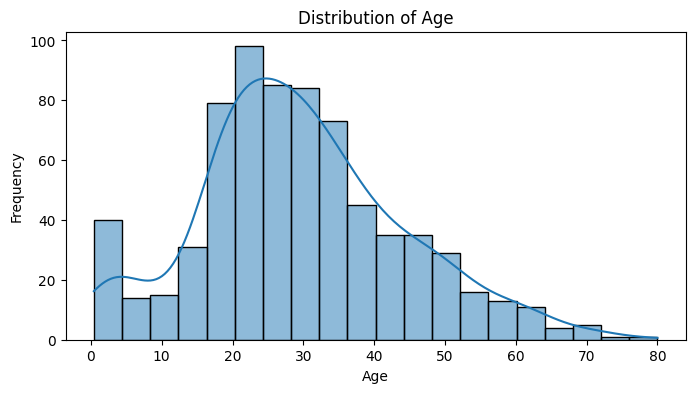

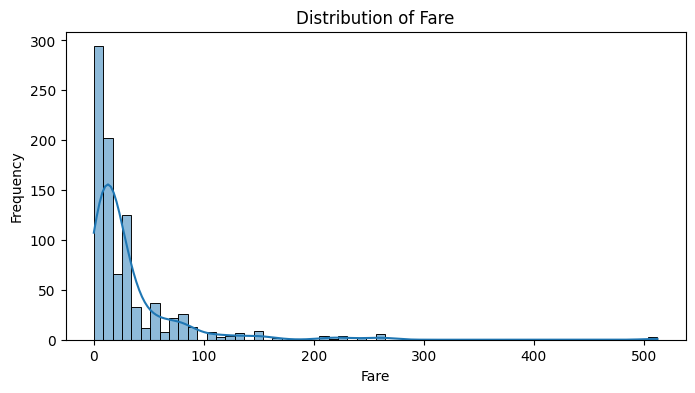

In [42]:
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

Here we only have 2 num columns: "Age", "Fare"
and in the column "Age" we can see that it almost follows the normal distribution(will be checked with the stats), hence maybe filling the null values with the mean will be better idea here

what about the "Fare", it has a long right tail, np.log can be used

In [35]:
df[cat_cols].nunique()

Name        891
Sex           2
Ticket      681
Cabin       147
Embarked      3
dtype: int64

In [45]:
for col in cat_cols:
    print(f"Value counts for {col}:")
    print(df[col].value_counts())
    print("\n")

Value counts for Name:
Name
Braund, Mr. Owen Harris                                1
Cumings, Mrs. John Bradley (Florence Briggs Thayer)    1
Heikkinen, Miss. Laina                                 1
Futrelle, Mrs. Jacques Heath (Lily May Peel)           1
Allen, Mr. William Henry                               1
                                                      ..
Montvila, Rev. Juozas                                  1
Graham, Miss. Margaret Edith                           1
Johnston, Miss. Catherine Helen "Carrie"               1
Behr, Mr. Karl Howell                                  1
Dooley, Mr. Patrick                                    1
Name: count, Length: 891, dtype: int64


Value counts for Sex:
Sex
male      577
female    314
Name: count, dtype: int64


Value counts for Ticket:
Ticket
347082              7
1601                7
CA. 2343            7
3101295             6
CA 2144             6
                   ..
PC 17590            1
17463               1
330877        

column "Name", we can get another column by taking only the title such Mr., Miss. and etc. and the len of the text(i do not think that it is gonna give some more info, but still i am gonna test it with the baseline by the weight it gives to this column)

column "Ticket", i am not really sure what these number realle represent but still i am gonna try to create new feat such only num or num+text(again will check the importance with baseline)

column "Cabin", this column can be seperated to 2 new feat: 1 with the first letter(seems to be like row number) and second one the number(leaving the number as it is unlikely to give some more info so new ideas are needed maybe turn 2 decimal number to new column such 2_num, if it is 1 number to 1_num, and etc.)

Right now i am gonna start little faeture engeenering 

In [60]:
df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
df['length_Name'] = df['Name'].apply(len)

In [62]:
df['Title'].value_counts()

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Ms                1
Mme               1
Don               1
Lady              1
Sir               1
Capt              1
the Countess      1
Jonkheer          1
Name: count, dtype: int64

We can see a lot of titles with only 1 occurence. the model most likely to not able to predict based on these low occurence but still instead of removing i am gonna use as it is

what about the length, we will see the importance through the baseline

In [66]:
#wanted to see if there are common prefixes in the 'Ticket' column
df['Ticket'].apply(lambda x: x.split(' ')[0] if not x.split(' ')[0].isdigit() else 'No_Prefix').value_counts()

Ticket
No_Prefix     661
PC             60
C.A.           27
STON/O         12
A/5            10
W./C.           9
SOTON/O.Q.      8
CA.             8
A/5.            7
SOTON/OQ        7
CA              6
STON/O2.        6
F.C.C.          5
SC/PARIS        5
C               5
S.O.C.          5
SC/Paris        4
LINE            4
PP              3
A/4.            3
A/4             3
S.O./P.P.       3
SC/AH           3
A./5.           2
P/PP            2
A.5.            2
WE/P            2
SOTON/O2        2
S.C./PARIS      2
S.C./A.4.       1
Fa              1
S.O.P.          1
SO/C            1
S.P.            1
W.E.P.          1
A4.             1
A/S             1
SC              1
SW/PP           1
SCO/W           1
W/C             1
S.W./PP         1
F.C.            1
C.A./SOTON      1
Name: count, dtype: int64

In [80]:
df['Ticket_is_digit'] = df['Ticket'].apply(lambda x: 1 if x.isdigit() else 0)

In [85]:
df["FamilySize"] = df["SibSp"].astype(int) + df["Parch"].astype(int) + 1

In [97]:
df['Cabin'].value_counts()

Cabin
G6             4
C23 C25 C27    4
B96 B98        4
F2             3
D              3
              ..
E17            1
A24            1
C50            1
B42            1
C148           1
Name: count, Length: 147, dtype: int64

In [ ]:
#i am gonna treat missing cabins as a separate category
df["Cabin_symbol"] = df['Cabin'].apply(lambda x: "missing" if pd.isna(x) else x[0])


In [112]:
num_data_cabin=df['Cabin'].apply(lambda x: "missing" if pd.isna(x) 
                  else x.split(" ")[0][1:] if not x[1:].isnumeric() 
                  else x[1:])

Here we can see that numeric data of cabin has a low common occurence hence i tried to create new categ column with 3 values

In [130]:
df['Cabin_digit'] = num_data_cabin.apply(lambda  x: "1_digit" if x=='' else x if x=="missing" else str(len(str(int(x))))+'_digit')

Removing unnecessary columns

In [133]:
df.drop(columns=['Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'], inplace=True)

In [134]:
df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,length_Name,Ticket_is_digit,FamilySize,Cabin_symbol,Cabin_digit
PassengerId,,,,,,,,,,,,
1,0,3,male,22.0,7.2500,S,Mr,23,0,2,missing,missing
2,1,1,female,38.0,71.2833,C,Mrs,51,0,2,C,2_digit
3,1,3,female,26.0,7.9250,S,Miss,22,0,1,missing,missing
4,1,1,female,35.0,53.1000,S,Mrs,44,1,2,C,3_digit
5,0,3,male,35.0,8.0500,S,Mr,24,1,1,missing,missing
